# XAI Tutorial 5: GradCAM

## Overview
In this tutorial, we will discuss the following topics:
* [Basic Pipeline Visualization](#tx05pipeline)
* [Extracting Intermediate Layer Gradients](#tx05grads)
* [GradCAM](#tx05cam)

First let's get some imports out of the way:

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

import fastestimator as fe
from fastestimator import Network, Pipeline, Estimator
from fastestimator.dataset.data import horse2zebra
from fastestimator.op.numpyop.multivariate import Resize
from fastestimator.op.numpyop.univariate import Normalize, ReadImage
from fastestimator.op.tensorop import LambdaOp
from fastestimator.op.tensorop.gradient import GradientOp
from fastestimator.op.tensorop.model import ModelOp
from fastestimator.trace.io import ImageViewer
from fastestimator.trace.xai import GradCAM
from fastestimator.util import ImgData

<a id='tx05pipeline'></a>

## Example Data and Pipeline

For this tutorial we will use some pictures of zebras with minimal pre-processing. Let's visualize some of the images to see what we're working with.

In [2]:
train_data, eval_data = horse2zebra.load_data(batch_size=5)
test_data = eval_data.split(range(5))  # We will just use the first 5 images for our visualizations
pipeline = Pipeline(test_data=test_data, 
                    ops=[ReadImage(inputs="B", outputs="B"), 
                         Resize(image_in="B", image_out="B", height=224, width=224),
                         Normalize(inputs="B", outputs="B", mean=(0.4914, 0.4822, 0.4465), std=(0.2471, 0.2435, 0.2616)),
                        ])

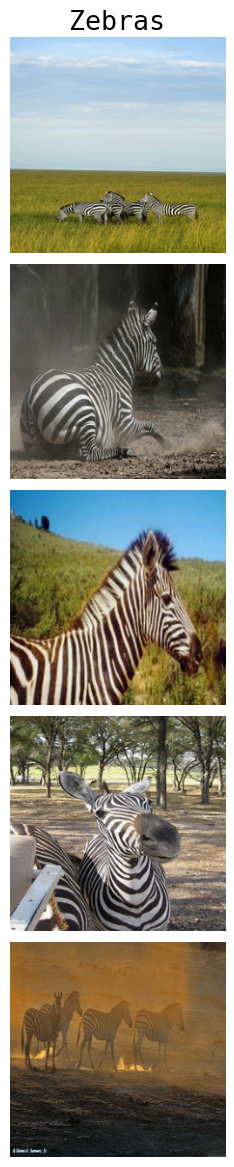

In [3]:
batch = pipeline.get_results(mode='test')
images = ImgData(Zebras=tf.convert_to_tensor(batch['B']))
fig = images.paint_figure()
plt.show()

<a id='tx05grads'></a>

## Extracting Intermediate Layer Gradients

We will use a pre-trained ResNet151 model for this example, with standard ImageNet weights. We will inspect the model to decide which layer we want to analyze with GradCAM.

In [4]:
model = fe.build(model_fn=lambda: tf.keras.applications.ResNet152V2(weights="imagenet"), optimizer_fn="adam")
print("\n".join([f"{idx}: {x.name}" for idx, x in enumerate(model._flatten_layers(include_self=False, recursive=True))]))

0: input_1
1: conv1_pad
2: conv1_conv
3: pool1_pad
4: pool1_pool
5: conv2_block1_preact_bn
6: conv2_block1_preact_relu
7: conv2_block1_1_conv
8: conv2_block1_1_bn
9: conv2_block1_1_relu
10: conv2_block1_2_pad
11: conv2_block1_2_conv
12: conv2_block1_2_bn
13: conv2_block1_2_relu
14: conv2_block1_0_conv
15: conv2_block1_3_conv
16: conv2_block1_out
17: conv2_block2_preact_bn
18: conv2_block2_preact_relu
19: conv2_block2_1_conv
20: conv2_block2_1_bn
21: conv2_block2_1_relu
22: conv2_block2_2_pad
23: conv2_block2_2_conv
24: conv2_block2_2_bn
25: conv2_block2_2_relu
26: conv2_block2_3_conv
27: conv2_block2_out
28: conv2_block3_preact_bn
29: conv2_block3_preact_relu
30: conv2_block3_1_conv
31: conv2_block3_1_bn
32: conv2_block3_1_relu
33: conv2_block3_2_pad
34: conv2_block3_2_conv
35: conv2_block3_2_bn
36: conv2_block3_2_relu
37: max_pooling2d
38: conv2_block3_3_conv
39: conv2_block3_out
40: conv3_block1_preact_bn
41: conv3_block1_preact_relu
42: conv3_block1_1_conv
43: conv3_block1_1_bn
44: 

This model has quite a few layers to choose from. We will try a convolution block near the end of the model. In order to get a GradCAM image we will need the gradients of the model prediction with respect to the intermediate layer outputs. This can be done using a combination of the ModelOp and GradientOp. We will also use a LambdaOp in order to get the gradients of only the model's most confident prediction. 

In [5]:
network = Network(ops=[
    ModelOp(model=model, inputs="B", outputs=["y_pred", "embedding"], intermediate_layers='conv5_block1_out'),
    LambdaOp(inputs="y_pred", outputs="y_pred_max", fn=lambda x: tf.reduce_max(x, axis=-1)),
    GradientOp(finals="y_pred_max", inputs="embedding", outputs="grads", mode="!train")
])

<a id='tx05cam'></a>

## GradCAM

Now it's time to generate some GradCAM images. You can read more about this method [here](https://arxiv.org/pdf/1610.02391.pdf).

In [6]:
traces = [
        GradCAM(images="B", grads="grads", preds="y_pred"),
        ImageViewer(inputs="gradcam", mode="test")
    ]

estimator = Estimator(pipeline=pipeline,
                      network=network,
                      traces=traces,
                      epochs=1,
                     )

FastEstimator-Warn: the key 'A' is being pruned since it is unused outside of the Pipeline. To prevent this, you can declare the key as an input of a Trace or TensorOp.


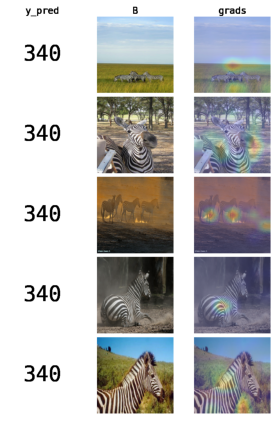

FastEstimator-Test: step: None; epoch: 1;


In [7]:
estimator.test()

ImageNet class 340 refers to zebras, so the model is correct for all of our data here. We can also see through the GradCAM output that the model sometimes seems to care more about the background of the image than the Zebras themselves. This might indicate that the model is using features that humans would deem non-robust in order to make its decisions. Let's compare this with an untrained model:

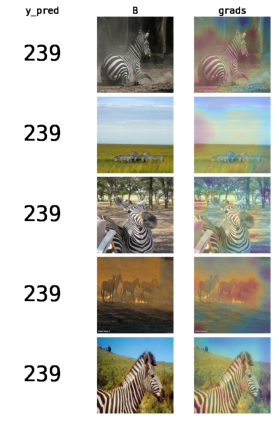

FastEstimator-Test: step: None; epoch: 1;


In [8]:
model = fe.build(model_fn=lambda: tf.keras.applications.ResNet152V2(weights=None), optimizer_fn="adam")
network = Network(ops=[
    ModelOp(model=model, inputs="B", outputs=["y_pred", "embedding"], intermediate_layers='conv5_block1_out'),
    LambdaOp(inputs="y_pred", outputs="y_pred_max", fn=lambda x: tf.reduce_max(x, axis=-1)),
    GradientOp(finals="y_pred_max", inputs="embedding", outputs="grads", mode="!train")
])
traces = [
        GradCAM(images="B", grads="grads", preds="y_pred"),
        ImageViewer(inputs="gradcam", mode="test")
    ]

estimator = Estimator(pipeline=pipeline,
                      network=network,
                      traces=traces,
                      epochs=1,
                     )
estimator.test()

As we can see from the images above, the untrained model seems to 'focus' all over the images with no apparent correlation to the zebras whatsoever. The training process clearly helps the network to focus in on more specific parts of the images for its predictions. 